In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

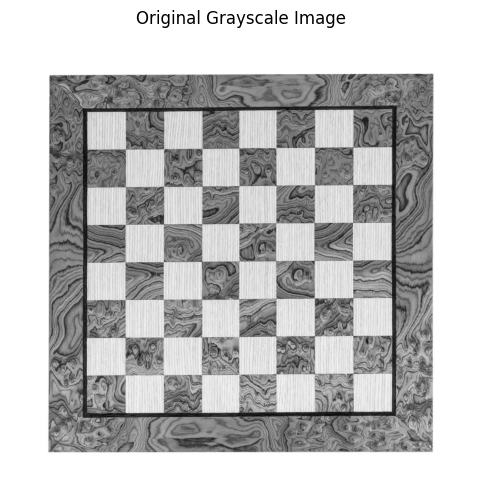

In [2]:
img_path = '../datasets/chessboard.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Gaussian Blurred Image')

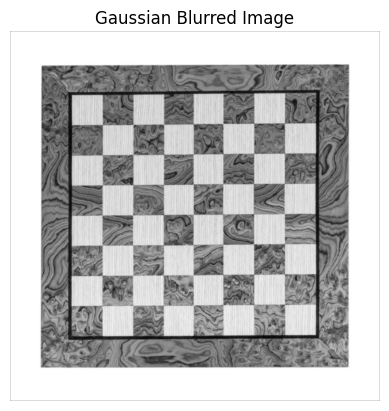

In [3]:
# Gaussian blur the image with improved parameters
def gaussian_kernel(size=5, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

def convolve(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape
    pad = kh // 2
    padded = np.pad(image, pad, mode='constant')
    result = np.zeros_like(image)
    
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            result[i, j] = np.sum(region * kernel)
    return result

blurred = convolve(img, gaussian_kernel(size=7, sigma=2.0))

plt.imshow(blurred, cmap='gray')
plt.axis('off')
plt.title('Gaussian Blurred Image')

Text(0.5, 1.0, 'Gradient Magnitude after Sobel Filter')

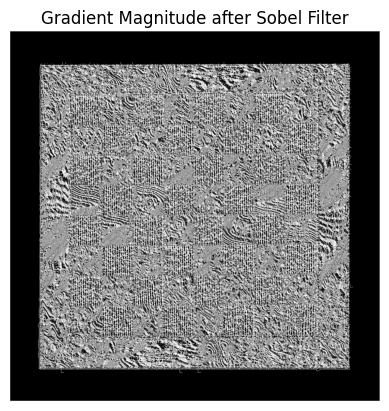

In [4]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)

    magnitude = np.hypot(Ix, Iy)
    magnitude = magnitude / magnitude.max() * 255

    angle = np.arctan2(Iy, Ix)
    return magnitude, angle

grad, angle = sobel_filters(blurred)

plt.imshow(grad, cmap='gray')
plt.axis('off')
plt.title('Gradient Magnitude after Sobel Filter')

Text(0.5, 1.0, 'Non-Maximum Suppression Result')

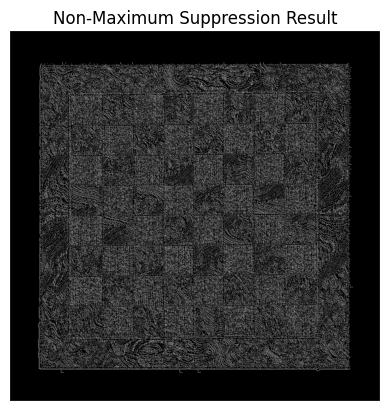

In [5]:
def non_max_suppression(mag, angle):
    h, w = mag.shape
    output = np.zeros((h, w), dtype=np.float32)
    angle = angle * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, h-1):
        for j in range(1, w-1):
            q, r = 255, 255

            # Angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = mag[i, j+1]
                r = mag[i, j-1]
            # Angle 45
            elif (22.5 <= angle[i,j] < 67.5):
                q = mag[i+1, j-1]
                r = mag[i-1, j+1]
            # Angle 90
            elif (67.5 <= angle[i,j] < 112.5):
                q = mag[i+1, j]
                r = mag[i-1, j]
            # Angle 135
            elif (112.5 <= angle[i,j] < 157.5):
                q = mag[i-1, j-1]
                r = mag[i+1, j+1]

            if mag[i,j] >= q and mag[i,j] >= r:
                output[i,j] = mag[i,j]
            else:
                output[i,j] = 0
    return output

nms = non_max_suppression(grad, angle)

plt.imshow(nms, cmap='gray')
plt.axis('off')
plt.title('Non-Maximum Suppression Result')

Text(0.5, 1.0, 'Thresholded Image')

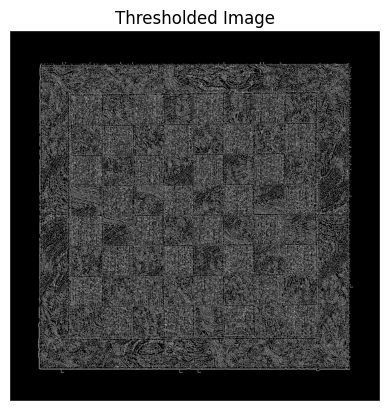

In [6]:
def threshold(img, low_ratio=0.05, high_ratio=0.15):
    high = img.max() * high_ratio
    low = high * low_ratio
    
    strong = 255
    weak = 25

    output = np.zeros_like(img, dtype=np.uint8)

    strong_i, strong_j = np.where(img >= high)
    weak_i, weak_j = np.where((img <= high) & (img >= low))

    output[strong_i, strong_j] = strong
    output[weak_i, weak_j] = weak

    return output, weak, strong

thresh, weak, strong = threshold(nms, low_ratio=0.05, high_ratio=0.15)

plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.title('Thresholded Image')

Text(0.5, 1.0, 'Final Edges after Hysteresis Thresholding')

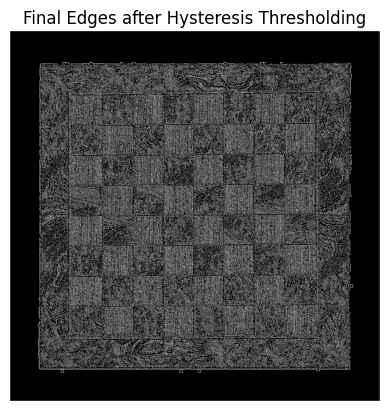

In [10]:
def hysteresis(img, weak, strong=255):
    h, w = img.shape
    for i in range(1, h-1):
        for j in range(1, w-1):
            if img[i, j] == weak:
                # If any of the 8 neighbors is strong
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

final_edges = hysteresis(thresh, weak, strong)

plt.imshow(final_edges, cmap='gray')
plt.axis('off')
plt.title('Final Edges after Hysteresis Thresholding')

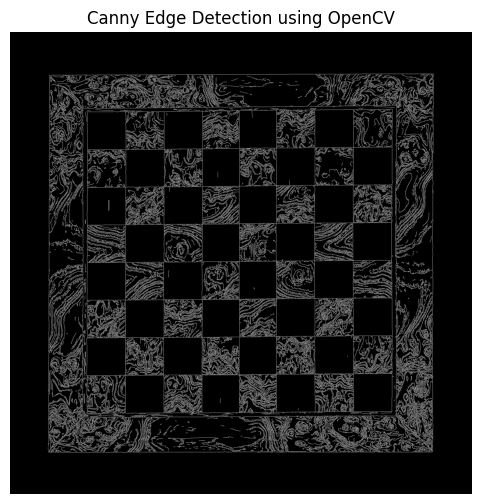

In [11]:
# Use the cv2 Canny function for comparison
canny_edges = cv2.Canny(img, 100, 200)
plt.figure(figsize=(6,6))
plt.imshow(canny_edges, cmap='gray')
plt.title('Canny Edge Detection using OpenCV')
plt.axis('off')
plt.show()

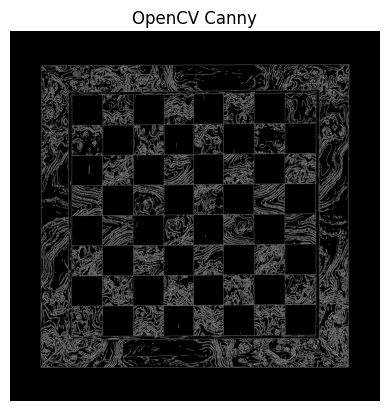

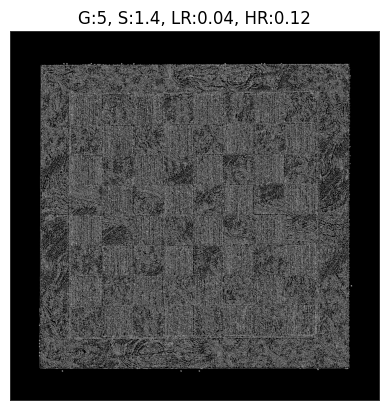

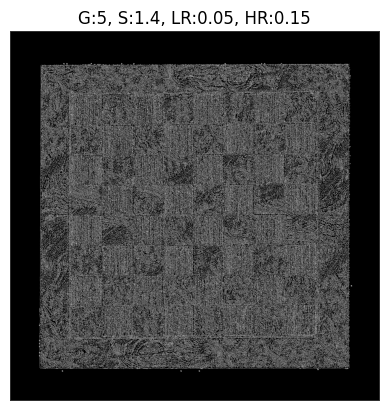

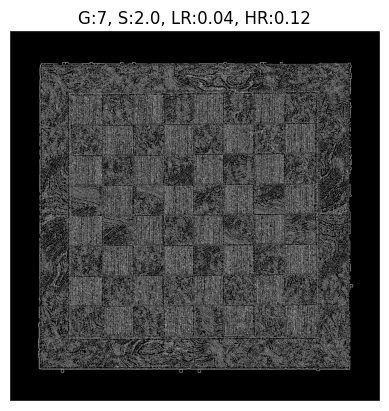

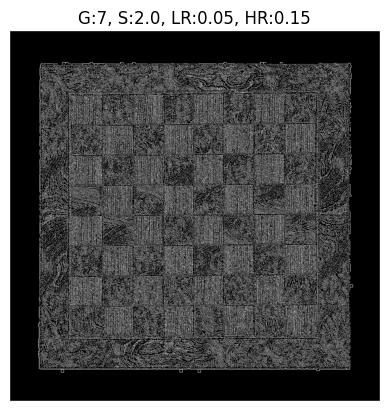

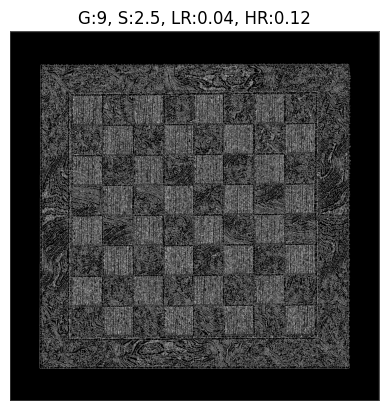

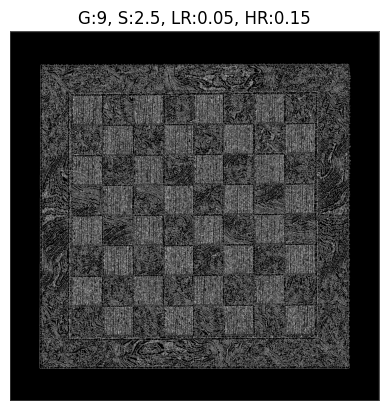

Image intensity range: 7 to 255
OpenCV low threshold (100) as ratio: 0.392
OpenCV high threshold (200) as ratio: 0.784


In [17]:
# Testing different parameter combinations to find the best one
def canny_edge_detector(img, gaussian_size=7, sigma=2.0, low_ratio=0.05, high_ratio=0.15):
    blurred = convolve(img, gaussian_kernel(size=gaussian_size, sigma=sigma))
    grad, angle = sobel_filters(blurred)
    nms = non_max_suppression(grad, angle)
    thresh, weak, strong = threshold(nms, low_ratio=low_ratio, high_ratio=high_ratio)
    final_edges = hysteresis(thresh.copy(), weak, strong)
    
    return final_edges

gaussian_sizes = [5, 7, 9]
sigma_values = [1.4, 2.0, 2.5]
low_ratios = [0.04, 0.05]
high_ratios = [0.12, 0.15]

for i, (size, sigma) in enumerate(zip(gaussian_sizes, sigma_values)):
	for j, (low_ratio, high_ratio) in enumerate(zip(low_ratios, high_ratios)):
		title = f'G:{size}, S:{sigma}, LR:{low_ratio}, HR:{high_ratio}'
		params = {
			'gaussian_size': size,
			'sigma': sigma,
			'low_ratio': low_ratio,
			'high_ratio': high_ratio
		}
		result = canny_edge_detector(img, **params)
		plt.imshow(result, cmap='gray')
		plt.title(title, fontsize=12)
		plt.axis('off')
		plt.show()

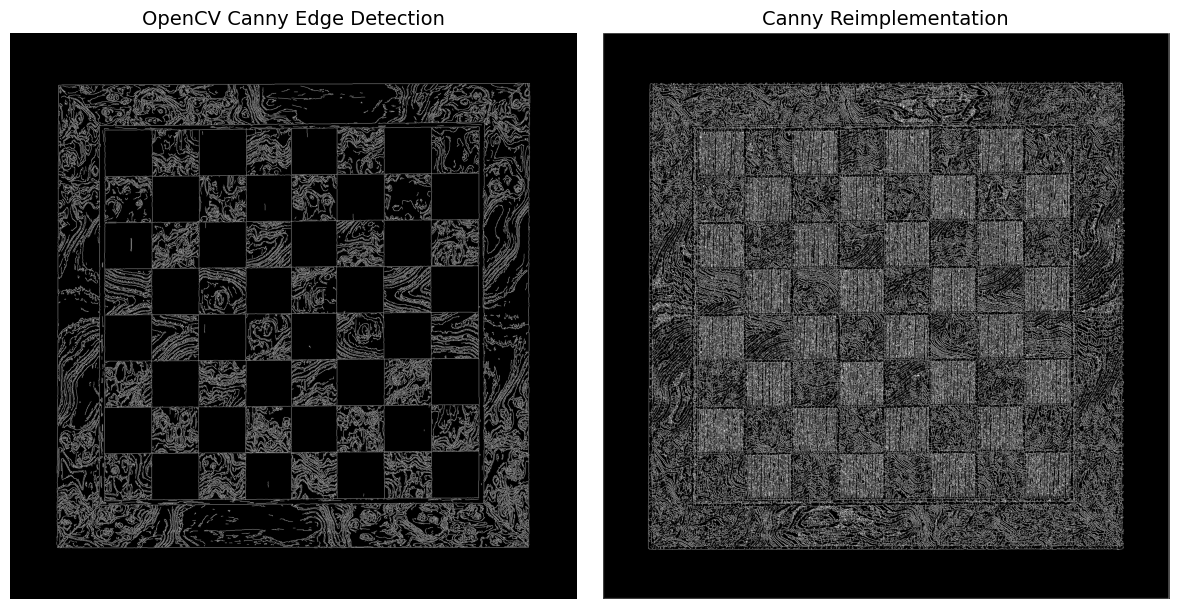

In [19]:
# Compare my best result with OpenCV's Canny implementation
def optimized_canny(img):
    blurred = convolve(img, gaussian_kernel(size=9, sigma=2.5))
    grad, angle = sobel_filters(blurred)
    nms = non_max_suppression(grad, angle)
    thresh, weak, strong = threshold(nms, low_ratio=0.05, high_ratio=0.15)
    final_edges = hysteresis(thresh.copy(), weak, strong)
    
    return final_edges

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# OpenCV result
canny_opencv = cv2.Canny(img, 100, 200)
axes[0].imshow(canny_opencv, cmap='gray')
axes[0].set_title('OpenCV Canny Edge Detection', fontsize=14)
axes[0].axis('off')

# Model's result
result = optimized_canny(img)
axes[1].imshow(result, cmap='gray')
axes[1].set_title('Canny Reimplementation', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()